In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Reading Data

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
dfs = pd.read_excel("000001data.xlsx")

Implementing Labelling algorithm 

In [ ]:
#labelling algorithm X is price and w is our threshould
def labeling(X,w):
    n = len(X)
    y = np.array([0 for i in range(n)])
    FP=X[0]
    xh = X[0]
    xl = X[0]
    HT = 0
    LT = 0
    cid = 0
    FP_N = 0
    for i in range(n):
        if(X[i] > FP + X[0]*w):
            xh,HT,FP_N,cid  = X[i],i,i,1
            break
        if(X[i] < FP - X[0]*w):
            xh,HT,FP_N,cid  = X[i],i,i,-1
            break
    for i in range(FP_N+1,n):
        if(cid > 0):
            if(X[i]>xh):
                xh,HT = X[i],i
            if(X[i] < xh - xh*w and LT<= HT ):
                for j in range(n):
                    if(j>LT and j<=HT):
                        y[j] = 1
                xl,LT,cid = X[i],i,-1
        if(cid < 0):
            if(X[i]<xl):
                xl,LT = X[i],i
            if(X[i] > xl + xl*w and HT<= LT ):
                for j in range(n):
                    if(j>HT and j<=LT):
                        y[j] = -1
                xh,HT,cid = X[i],i,1
    return y

labelling data

In [ ]:
label=labeling(dfs["closingprice"],0.15)    

Creat windows with size 11 

In [ ]:
closing_price= dfs['closingprice']

#windows size is 11
expand_data = np.array([closing_price[i:i+11] for i in range(len(closing_price) - 10) ])

normalize Data 
\begin{align*}
        f_{ij} & = \frac{x_{ij} - M^{\lambda}_{i}}{M^{\lambda}_{i}} ,x_{ij} \in X\\
        M^{\lambda}_{s}& = \frac{\sum_{i=s}^{s+ \lambda -1} x_i}{\lambda} , x_i \in x
    \end{align*}

In [ ]:

#normalizatin
final_data_x = expand_data / np.mean(expand_data,axis = 1).reshape((len(expand_data) , 1))
final_data_x = final_data_x - np.ones((len(final_data_x) ,1))

In [ ]:
#finalizing data
final_data_y = label[10:]
#split data to test and train
x_train = final_data_x[0:3011]
y_train = final_data_y[0:3011]
x_test= final_data_x[3011:]
y_test = final_data_y[3011:]

#(-1,1) --> (0,1)
y_train = (y_train + 1)//2
y_test = (y_test + 1)//2

x_train =x_train.reshape(x_train.shape[0],x_train.shape[1] , 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1] , 1)

Training data with 2 layer LSTM with hidden size 50 

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
with tf.device('/device:GPU:0'):
  model=Sequential()
  model.add(tf.compat.v1.keras.layers.CuDNNLSTM(50,return_sequences=True,input_shape=(11,1)))
  model.add(Dropout(0.1))
  model.add(tf.compat.v1.keras.layers.CuDNNLSTM(50))
  model.add(Dropout(0.1))
  model.add(Dense(1, activation='sigmoid'))
  opt = tf.keras.optimizers.Adam(beta_1=0.9,beta_2=0.999,learning_rate=0.02)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=20,batch_size=64,verbose=2)

Epoch 1/20
48/48 - 8s - loss: 0.6791 - accuracy: 0.5809 - val_loss: 0.7154 - val_accuracy: 0.4949
Epoch 2/20
48/48 - 0s - loss: 0.6097 - accuracy: 0.6702 - val_loss: 0.6090 - val_accuracy: 0.6782
Epoch 3/20
48/48 - 0s - loss: 0.5749 - accuracy: 0.7131 - val_loss: 0.6012 - val_accuracy: 0.6816
Epoch 4/20
48/48 - 0s - loss: 0.5626 - accuracy: 0.7187 - val_loss: 0.5984 - val_accuracy: 0.6701
Epoch 5/20
48/48 - 0s - loss: 0.5583 - accuracy: 0.7164 - val_loss: 0.6011 - val_accuracy: 0.6654
Epoch 6/20
48/48 - 0s - loss: 0.5420 - accuracy: 0.7250 - val_loss: 0.5932 - val_accuracy: 0.6868
Epoch 7/20
48/48 - 0s - loss: 0.5353 - accuracy: 0.7376 - val_loss: 0.6291 - val_accuracy: 0.6759
Epoch 8/20
48/48 - 0s - loss: 0.5412 - accuracy: 0.7313 - val_loss: 0.5889 - val_accuracy: 0.6879
Epoch 9/20
48/48 - 0s - loss: 0.5349 - accuracy: 0.7293 - val_loss: 0.5869 - val_accuracy: 0.6910
Epoch 10/20
48/48 - 0s - loss: 0.5317 - accuracy: 0.7227 - val_loss: 0.6148 - val_accuracy: 0.6686
Epoch 11/20
48/48 -

Training data with 2 layer GRU with hidden size 50 

In [ ]:
with tf.device('/device:GPU:0'):
  model=Sequential()
  model.add(tf.compat.v1.keras.layers.CuDNNGRU(50,return_sequences=True,input_shape=(11,1)))
  model.add(Dropout(0.1))
  model.add(tf.compat.v1.keras.layers.CuDNNGRU(50))
  model.add(Dropout(0.1))
  model.add(Dense(1, activation='sigmoid'))
  opt = tf.keras.optimizers.Adam(beta_1=0.9,beta_2=0.999,learning_rate=0.02)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=20,batch_size=64,verbose=2)

Epoch 1/20
48/48 - 2s - loss: 0.6589 - accuracy: 0.5991 - val_loss: 0.5970 - val_accuracy: 0.6863
Epoch 2/20
48/48 - 0s - loss: 0.5548 - accuracy: 0.7240 - val_loss: 0.5979 - val_accuracy: 0.6803
Epoch 3/20
48/48 - 0s - loss: 0.5448 - accuracy: 0.7343 - val_loss: 0.6019 - val_accuracy: 0.6725
Epoch 4/20
48/48 - 0s - loss: 0.5354 - accuracy: 0.7317 - val_loss: 0.6019 - val_accuracy: 0.6834
Epoch 5/20
48/48 - 0s - loss: 0.5297 - accuracy: 0.7370 - val_loss: 0.5852 - val_accuracy: 0.6947
Epoch 6/20
48/48 - 0s - loss: 0.5269 - accuracy: 0.7336 - val_loss: 0.5958 - val_accuracy: 0.6868
Epoch 7/20
48/48 - 0s - loss: 0.5153 - accuracy: 0.7473 - val_loss: 0.5936 - val_accuracy: 0.6876
Epoch 8/20
48/48 - 0s - loss: 0.5259 - accuracy: 0.7346 - val_loss: 0.5940 - val_accuracy: 0.6957
Epoch 9/20
48/48 - 0s - loss: 0.5063 - accuracy: 0.7512 - val_loss: 0.5889 - val_accuracy: 0.6840
Epoch 10/20
48/48 - 0s - loss: 0.5129 - accuracy: 0.7499 - val_loss: 0.6013 - val_accuracy: 0.6790
Epoch 11/20
48/48 -

#My approach

sampling form 44 previous data with sample size 11 and equal distance between samples

In [ ]:
expand_data = np.array([closing_price[i:i+44] for i in range(len(closing_price) - 43) ])


#x_df = np.array([np.convolve(x,np.ones(4)/4,mode='valid') for x in x_df])
final_data_x = np.array([np.array([x[i] for i in range(3,44,4)]) for x in expand_data])
final_data_x = final_data_x / np.mean(final_data_x,axis = 1).reshape((len(final_data_x) , 1))
final_data_x = final_data_x - np.ones((len(final_data_x) ,1))

final_data_y = label[43:]


x_train = final_data_x[0:3011]
y_train = final_data_y[0:3011]
x_test= final_data_x[3011:]
y_test = final_data_y[3011:]


y_train = (y_train + 1)//2
y_test = (y_test + 1)//2


x_train =x_train.reshape(x_train.shape[0],x_train.shape[1] , 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1] , 1)


In [ ]:
with tf.device('/device:GPU:0'):
  model=Sequential()
  model.add(tf.compat.v1.keras.layers.CuDNNGRU(50,return_sequences=True,input_shape=(11,1)))
  model.add(Dropout(0.1))
  model.add(tf.compat.v1.keras.layers.CuDNNGRU(50))
  model.add(Dropout(0.1))
  model.add(Dense(1, activation='sigmoid'))
  opt = tf.keras.optimizers.Adam(beta_1=0.9,beta_2=0.999,learning_rate=0.02)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=20,batch_size=64,verbose=2)

Epoch 1/20
48/48 - 2s - loss: 0.6129 - accuracy: 0.6533 - val_loss: 0.5397 - val_accuracy: 0.7354
Epoch 2/20
48/48 - 0s - loss: 0.5206 - accuracy: 0.7386 - val_loss: 0.5497 - val_accuracy: 0.7038
Epoch 3/20
48/48 - 0s - loss: 0.4904 - accuracy: 0.7669 - val_loss: 0.5291 - val_accuracy: 0.7275
Epoch 4/20
48/48 - 0s - loss: 0.4736 - accuracy: 0.7795 - val_loss: 0.5497 - val_accuracy: 0.7007
Epoch 5/20
48/48 - 0s - loss: 0.4541 - accuracy: 0.7924 - val_loss: 0.5881 - val_accuracy: 0.6781
Epoch 6/20
48/48 - 0s - loss: 0.4669 - accuracy: 0.7778 - val_loss: 0.5355 - val_accuracy: 0.7275
Epoch 7/20
48/48 - 0s - loss: 0.4432 - accuracy: 0.8067 - val_loss: 0.5858 - val_accuracy: 0.6996
Epoch 8/20
48/48 - 0s - loss: 0.4420 - accuracy: 0.7921 - val_loss: 0.5690 - val_accuracy: 0.7151
Epoch 9/20
48/48 - 0s - loss: 0.4252 - accuracy: 0.8084 - val_loss: 0.5494 - val_accuracy: 0.7207
Epoch 10/20
48/48 - 0s - loss: 0.4279 - accuracy: 0.8044 - val_loss: 0.5702 - val_accuracy: 0.6912
Epoch 11/20
48/48 -

In [ ]:
x_train = final_data_x[0:3011]
y_train = final_data_y[0:3011]
x_test= final_data_x[3011:]
y_test = final_data_y[3011:]

fea = x_train.shape[1]
rn = np.random.rand(fea,50)
x_train = np.dot(x_train,rn)
x_test = np.dot(x_test,rn)





In [ ]:
x_train.shape

(3011, 100)

In [ ]:
y_train = (y_train + 1)//2
y_test = (y_test + 1)//2


x_train =x_train.reshape(x_train.shape[0],x_train.shape[1] , 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1] , 1)


In [ ]:
with tf.device('/device:GPU:0'):
  model=Sequential()
  model.add(tf.compat.v1.keras.layers.CuDNNGRU(50,return_sequences=True,input_shape=(11,1)))
  model.add(Dropout(0.1))
  model.add(tf.compat.v1.keras.layers.CuDNNGRU(50))
  model.add(Dropout(0.1))
  model.add(Dense(1, activation='sigmoid'))
  opt = tf.keras.optimizers.Adam(beta_1=0.9,beta_2=0.999,learning_rate=0.02)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=20,batch_size=64,verbose=2)

Epoch 1/20
48/48 - 2s - loss: 0.6680 - accuracy: 0.5991 - val_loss: 0.6534 - val_accuracy: 0.6273
Epoch 2/20
48/48 - 0s - loss: 0.5865 - accuracy: 0.7001 - val_loss: 0.5865 - val_accuracy: 0.6986
Epoch 3/20
48/48 - 0s - loss: 0.5490 - accuracy: 0.7240 - val_loss: 0.5739 - val_accuracy: 0.6928
Epoch 4/20
48/48 - 0s - loss: 0.5238 - accuracy: 0.7476 - val_loss: 0.5567 - val_accuracy: 0.7154
Epoch 5/20
48/48 - 0s - loss: 0.5287 - accuracy: 0.7522 - val_loss: 0.5540 - val_accuracy: 0.7307
Epoch 6/20
48/48 - 0s - loss: 0.5235 - accuracy: 0.7400 - val_loss: 0.6425 - val_accuracy: 0.7186
Epoch 7/20
48/48 - 0s - loss: 0.5110 - accuracy: 0.7559 - val_loss: 0.5431 - val_accuracy: 0.7299
Epoch 8/20
48/48 - 0s - loss: 0.4976 - accuracy: 0.7635 - val_loss: 0.5598 - val_accuracy: 0.7059
Epoch 9/20
48/48 - 0s - loss: 0.5048 - accuracy: 0.7599 - val_loss: 0.5390 - val_accuracy: 0.7249
Epoch 10/20
48/48 - 0s - loss: 0.5036 - accuracy: 0.7635 - val_loss: 0.5947 - val_accuracy: 0.6733
Epoch 11/20
48/48 -

Accuracy:0.712257
Precision:0.752739
Recall:0.699467
F1 score:0.725126


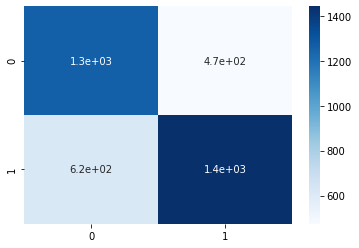

In [ ]:
from sklearn import metrics
import seaborn as sns
y_pred = model.predict(x_test)
y_pred = np.array([1 if y >=0.5 else 0 for y in y_pred])
print("Accuracy:{:.6f}".format(metrics.accuracy_score(y_test, y_pred)))
print("Precision:{:.6f}".format(metrics.precision_score(y_test, y_pred)))
print("Recall:{:.6f}".format(metrics.recall_score(y_test, y_pred)))
print("F1 score:{:.6f}".format(metrics.f1_score(y_test, y_pred)))
    
# Print Confusion Matrix
confusion_matrix = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred)) 
sns.heatmap(confusion_matrix, annot=True, cmap="Blues");

In [ ]:
y_pred

array([[0.67370343],
       [0.6712601 ],
       [0.6663634 ],
       ...,
       [0.43360442],
       [0.4261445 ],
       [0.41190097]], dtype=float32)